# Interact with fission product yields in ENDF-6 format (MF=8, MT=454/459)

First let's import `sandy` and the other python packages for formatting and postprocessing that are used in this notebook.

In [1]:
import filecmp
import yaml
import h5py

import matplotlib.pyplot as plt
import pandas as pd

import sandy

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook")

pd.options.display.float_format = '{:.5e}'.format

%matplotlib notebook

#%load_ext autoreload
#%autoreload 2

## Parsing the data in ENDF-6 format

The first thing that we want to do with an evaluated nuclear data  file in ENDF-6 format is to load its content into python using `sandy`.
By calling `sandy.Endf6.from_file`, the ENDF-6 file is parsed and its content is split into text sections, each of them indexed by a unique combination of MAT, MF and MT numbers. 

Below we report an example using a custom file `"fy.txt"` pre-edited for the purposes of this notebook.
The file content is loaded into the `Endf6` instance that we named `tape`.

In [2]:
file = "fy.txt"
tape = sandy.Endf6.from_file(file)
tape.to_series().head(10)

MAT   MF  MT 
3540  1   451     9.223300+4 2.310380+2         -1          1  ...
      8   454     9.223300+4 2.310380+2          1          0  ...
          459     9.223300+4 2.310380+2          1          0  ...
3542  1   451     9.223500+4 2.330250+2         -1          1  ...
      8   454     9.223500+4 2.330250+2          2          0  ...
          459     9.223500+4 2.330250+2          2          0  ...
3586  1   451     9.423900+4 2.369990+2         -1          1  ...
      8   454     9.423900+4 2.369990+2          1          0  ...
          459     9.423900+4 2.369990+2          1          0  ...
Name: fy.txt, dtype: object

Now, the information available in each `(MAT,MF,MT)` section in ASCII format can be extracted using method `.read_section`, 
as shown below.

> Recall that MF=8 MT=454 are the indices for independent fission yields, MF=8 MT=459 for cumulative fission yields

In [3]:
mat = 3540
mf = 8
mt = 454

section = tape.read_section(mat, mf, mt)

For a better visualization of the FY data structure generated by `.read_section` we resort to the `yaml` package and we print only the first 11 lines.

In [4]:
print("\n".join(yaml.dump(section).splitlines()[:11]))

AWR: 231.038
E:
  0.0253:
    INTERP: 0
    ZAP:
      10010:
        DFY: 1.1412e-05
        FY: 3.3376999999999996e-05
      10020:
        DFY: 2.2832e-06
        FY: 8.466e-06


The data contained in the ENDF-6 section are stored in nested dictionaries, 
according to the following structure that tries and replicate the ENDF-6 hierarchy.

```yaml
    AWR : atomic weight ratio
    E :   # dictionary of tabulated energies at which fission yields are given
        energy :  # energy of the neutron causing fission (eV)
            INTERP : interpolation scheme between this and the following energy point
            ZAP :   # dictionary of fission products
                Z*1000 + A*10 + M :
                    FY : fission yield (fraction)
                    DFY : uncertainty on fission yield (same unit as FY)
                Z2*1000 + A2*10 + M2 : ...
        energy_2 : ...
```

## Create a `sandy.Fy` object

Class `sandy.Fy` was developed to store and process fission yield data.

The ASCII content in a `sandy.Endf6` instance can be directly imported into a `sandy.Fy` instance using 
classmethod `.from_endf6`, where the `sandy.Endf6` object is passed as an argument.

In [5]:
fy = sandy.Fy.from_endf6(tape)
fy

    MAT   MT     ZAM    ZAP           E          FY
0  3540  454  922330  10010 2.53000e-02 3.33770e-05
1  3540  454  922330  10020 2.53000e-02 8.46600e-06
2  3540  454  922330  10030 2.53000e-02 1.14000e-04
3  3540  454  922330  20030 2.53000e-02 0.00000e+00
4  3540  454  922330  20040 2.53000e-02 2.11000e-03

Notice that, although the `sandy.Fy` instance has the string representation of a `pd.DataFrame`, **the `sandy.Fy` class does not inherit from the `pd.DataFrame` class!**

The `pd.DataFrame` containing the source data is rather stored in attribute `.data`, which contains fission yields FY together with the corresponding MAT, MT, ZAM, ZAP, and energy E values.
Here ZAM and ZAP are the `Z*10000 + A*10 + M` representation for the parent and daugther nuclides.

## How to filter the fission yield data 

The fission yield data can be filtered directly applying the `pandas` functionality to attribute `.data`.
However, we recommend using method `.filter_by` to make sure that the returned object be still a `sandy.Fy` instance.

Below are two examples where `sandy.Fy` instances are created first by filtering only the cumulative yield at thermal energy for the fission of U-235 (`ZAM=922350`), and then keeping only the cumulative fission yields at thermal energy for Cs-137 (`ZAP=551370`) independently of the fissioning nuclide.

In [6]:
cfyU235 = fy.filter_by("ZAM", 922350).filter_by("MT", 459).filter_by("E", 2.53e-2)
cfyU235

       MAT   MT     ZAM    ZAP           E          FY
4019  3542  459  922350  10010 2.53000e-02 1.71100e-05
4020  3542  459  922350  10020 2.53000e-02 8.40000e-06
4021  3542  459  922350  10030 2.53000e-02 1.08000e-04
4022  3542  459  922350  20030 2.53000e-02 1.08000e-04
4023  3542  459  922350  20040 2.53000e-02 1.70210e-03

In [7]:
cfyCs137 = fy.filter_by("ZAP", 551370).filter_by("MT", 459).filter_by("E", 2.53e-2)
cfyCs137

       MAT   MT     ZAM     ZAP           E          FY
1843  3540  459  922330  551370 2.53000e-02 6.20450e-02
4761  3542  459  922350  551370 2.53000e-02 6.22080e-02
7887  3586  459  942390  551370 2.53000e-02 6.58810e-02

## Plotting

Plotting fission yields as a function of mass or charge can be cumbersome with the current information available in a `sandy.Fy` instance.
In fact, to do so columns ZAM or ZAP should be *expanded* to their source components Z, A, M, where Z is the charge number, A is the number of nucleons and M is the metastate number.

Here we introduce two new methods that do exactly what required: `._expand_zap` and `._expand_zam`.

The first method returns a copy a of the `.data` attribute with three extra columns: the Z, A and M of the fission product.
The second method returns a copy a of the `.data` attribute with three extra columns: the Z, A and M of the fissioning nuclide.

> Methods `._expand_zap` and `._expand_zam` return a `pd.DataFrame` and not a `sandy.Fy` instance.

In [8]:
cfyU235._expand_zap().head()

,MAT,MT,ZAM,ZAP,E,FY,Z,A,M
0,3542,459,922350,10010,2.53000e-02,1.71100e-05,1,1,0
1,3542,459,922350,10020,2.53000e-02,8.40000e-06,1,2,0
2,3542,459,922350,10030,2.53000e-02,1.08000e-04,1,3,0
3,3542,459,922350,20030,2.53000e-02,1.08000e-04,2,3,0
4,3542,459,922350,20040,2.53000e-02,1.70210e-03,2,4,0


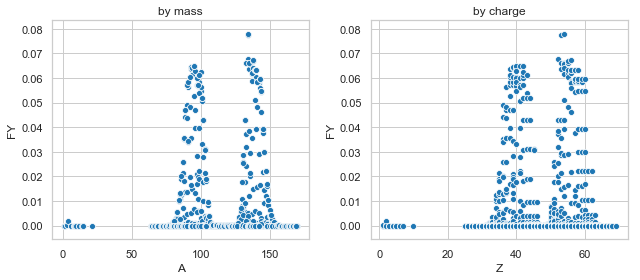

In [9]:
fig, ax = plt.subplots(1,2, figsize=(9,4))
ax[0] = sns.scatterplot(x="A", y="FY", data=cfyU235._expand_zap(), ax=ax[0])
ax[1] = sns.scatterplot(x="Z", y="FY", data=cfyU235._expand_zap(), ax=ax[1])

ax[0].set_title("by mass")
ax[1].set_title("by charge")

plt.tight_layout();

In [10]:
cfyCs137._expand_zam().head()

,MAT,MT,ZAM,ZAP,E,FY,Z,A,M
0,3540,459,922330,551370,2.53000e-02,6.20450e-02,92,233,0
1,3542,459,922350,551370,2.53000e-02,6.22080e-02,92,235,0
2,3586,459,942390,551370,2.53000e-02,6.58810e-02,94,239,0


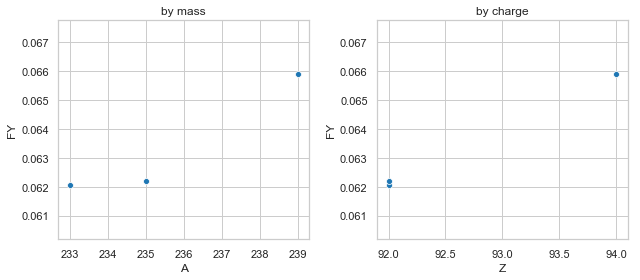

In [11]:
fig, ax = plt.subplots(1,2, figsize=(9,4))
ax[0] = sns.scatterplot(x="A", y="FY", data=cfyCs137._expand_zam(), ax=ax[0])
ax[1] = sns.scatterplot(x="Z", y="FY", data=cfyCs137._expand_zam(), ax=ax[1])

ax[0].set_title("by mass")
ax[1].set_title("by charge")

plt.tight_layout();

## Tabulated fission yields as a function of energy

It is sometimes important to have access to the fission yield data (either cumulaitve or independent, not both) as a tabulated function of energy.
This can be done by calling method `.energy_table` where the fissioning nuclide is specified as an argument either as a ZAM or MAT number. 

Below we report an example for the cumulative yields of U-235, where only a few fission products are selected.

In [12]:
fy.energy_table(459, zam=922350)[[380900, 551330, 551370, 581410]]

ZAP,380900,551330,551370,581410
E,,,,
2.53000e-02,5.72900e-02,6.59630e-02,6.22080e-02,5.85540e-02
4.00000e+05,5.22080e-02,6.61180e-02,5.88890e-02,5.79500e-02


## Write to ENDF-6 file

to be written

## Write to HDF5 file

Codes like ALEPH read fission yields from nuclear data files in HDF5 format.
To produce such files we can use `sandy` and method `Fy.to_hdf5`, which extracts and stores energy tables for each set of fission yields found in the `Fy` object.

As an example, we can transfer the whole content of the `fy` instance to a HDF5 file `file='fy.hdf5'`.

In [13]:
file = 'fy.hdf5'
fy.to_hdf5(file, "jeff_33");

The group key for each set of fission yields is `"library/fy/kind/iZAM"`, where
    * library: is the lowercase name of the library
    * fy: is the key "fy"
    * kind: is either "independent" or "cumulative"
    * iZAM: is the ZAM number proceeded by prefix "i"

> The energy values in the HDF5 file are in MeV.

## Apply custom perturbations

to be written